### Imports

In [2]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re

### Get CSV files

In [3]:
csv_files = glob.glob(os.path.join('', "csv_files/*.csv"))

df_list = []
for file in csv_files:
    temp_df = pd.read_csv(file)
    df_list.append(temp_df)

df = pd.concat(df_list, ignore_index=True)

### Analyze Dataframe

In [4]:
comment_counts = df['comment'].value_counts()
uname_counts = df['user_name'].value_counts()

duplicate_comments = comment_counts[comment_counts > 1].index
duplicate_comments = df[df['comment'].isin(duplicate_comments)][['user_name', 'comment', 'title']]
duplicate_comments = duplicate_comments.replace({r'\n': ' '}, regex=True).sort_values(by='comment')
duplicate_comments.to_csv("output_csv/duplicate_comments.csv", index=False, encoding='utf-8')

user_stats = df.groupby('user_name').agg(
    number_of_videos=('title', 'nunique'),
    number_of_comments=('comment', 'count')
).reset_index()
user_stats = user_stats[user_stats['number_of_videos'] > 1]

duplicate_unames = uname_counts[uname_counts > 1].index
duplicate_unames = df[df['user_name'].isin(user_stats['user_name'])][['user_name', 'comment', 'title']]
duplicate_unames = duplicate_unames.replace({r'\n': ' '}, regex=True).sort_values(by='user_name')
duplicate_unames.to_csv("output_csv/duplicate_user_names.csv", index=False, encoding='utf-8')


user_stats.to_csv("output_csv/user_stats.csv", index=False, encoding='utf-8')

### Visualise Videos with duplicate comments and usernames

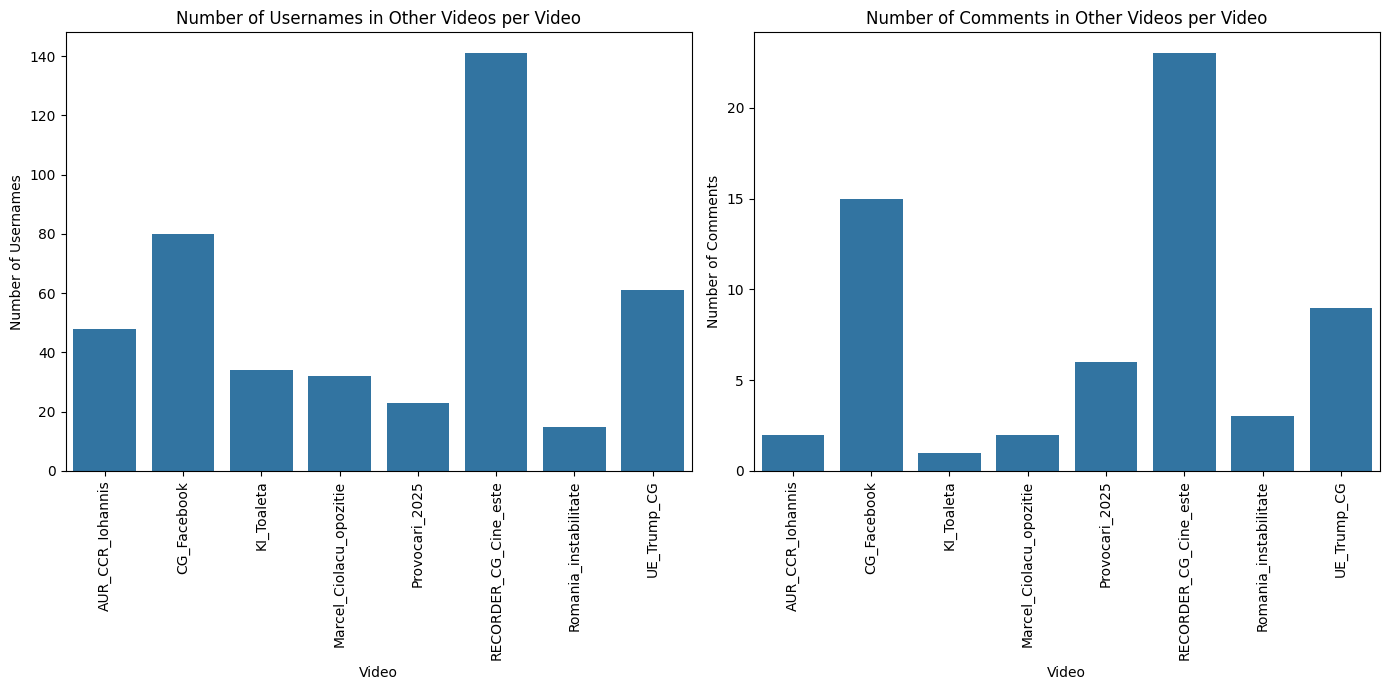

In [5]:
video_usernames = df.groupby('title')['user_name'].nunique()

def count_usernames_in_other_videos(video, video_usernames):
    video_usernames_set = set(video_usernames)
    usernames_in_other_videos = 0

    for username in video_usernames_set:
        other_videos = df[df['user_name'] == username]
        other_videos = other_videos[~other_videos['title'].isin([video['title'].iloc[0]])]
        if not other_videos.empty:
            usernames_in_other_videos += 1

    return usernames_in_other_videos

def count_comments_in_other_videos(video, video_comments, video_name):
    video_comments_set = set(video_comments)
    comments_in_other_videos = 0

    for comment in video_comments_set:
        other_videos = df[df['comment'] == comment]
        other_videos = other_videos[~other_videos['title'].isin([video['title'].iloc[0]])]
        if not other_videos.empty:
            comments_in_other_videos += 1

    return comments_in_other_videos

usernames_in_other_videos_list = []
comments_in_other_videos_list = []
video_names = []

for video_name, video in df.groupby('title'):
    video_usernames = video['user_name'].unique()
    video_comments = video['comment'].unique()
    
    usernames_in_other_videos = count_usernames_in_other_videos(video, video_usernames)
    comments_in_other_videos = count_comments_in_other_videos(video, video_comments, video_name)
    
    usernames_in_other_videos_list.append(usernames_in_other_videos)
    comments_in_other_videos_list.append(comments_in_other_videos)
    video_names.append(video_name)

results_df = pd.DataFrame({
    'video_name': video_names,
    'usernames_in_other_videos': usernames_in_other_videos_list,
    'comments_in_other_videos': comments_in_other_videos_list
})

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

sns.barplot(x=results_df['video_name'], y=results_df['usernames_in_other_videos'], ax=axes[0])
axes[0].set_title('Number of Usernames in Other Videos per Video')
axes[0].set_xlabel('Video')
axes[0].set_ylabel('Number of Usernames')
axes[0].tick_params(axis='x', rotation=90)

sns.barplot(x=results_df['video_name'], y=results_df['comments_in_other_videos'], ax=axes[1])
axes[1].set_title('Number of Comments in Other Videos per Video')
axes[1].set_xlabel('Video')
axes[1].set_ylabel('Number of Comments')
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

### Analyse repetition of users and comments accross videos

In [ ]:
def count_usernames_in_other_videos(video, video_usernames):
    video_usernames_set = set(video_usernames)
    
    usernames_in_other_videos = 0
    for username in video_usernames_set:
        other_videos = df[df['user_name'] == username]
        other_videos = other_videos[~other_videos['title'].isin([video['title'].iloc[0]])]
        if not other_videos.empty:
            usernames_in_other_videos += 1
    return usernames_in_other_videos

def count_comments_in_other_videos(video, video_comments):
    video_comments_set = set(video_comments)
    
    comments_in_other_videos = 0
    for comment in video_comments_set:
        other_videos = df[df['comment'] == comment]
        other_videos = other_videos[~other_videos['title'].isin([video['title'].iloc[0]])]
        if not other_videos.empty:
            comments_in_other_videos += 1
    return comments_in_other_videos

usernames_in_other_videos_list = []
comments_in_other_videos_list = []
video_names = []
comments_count_list = []

for video_name, video in df.groupby('title'):
    video_usernames = video['user_name'].unique()
    video_comments = video['comment'].unique()
    
    usernames_in_other_videos = count_usernames_in_other_videos(video, video_usernames)
    comments_in_other_videos = count_comments_in_other_videos(video, video_comments)
    
    usernames_in_other_videos_list.append(usernames_in_other_videos)
    comments_in_other_videos_list.append(comments_in_other_videos)
    video_names.append(video_name)
    comments_count_list.append(len(video_comments))

results_df = pd.DataFrame({
    'video_name': video_names,
    'usernames_in_other_videos': usernames_in_other_videos_list,
    'comments_in_other_videos': comments_in_other_videos_list,
    'comments_count': comments_count_list
})

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

sns.scatterplot(x=results_df['comments_count'], y=results_df['usernames_in_other_videos'], ax=axes[0])
axes[0].set_title('Usernames in Other Videos vs. Number of Comments')
axes[0].set_xlabel('Number of Comments')
axes[0].set_ylabel('Number of Usernames in Other Videos')

for i in range(len(results_df)):
    axes[0].annotate(results_df['video_name'].iloc[i], 
                     (results_df['comments_count'].iloc[i], results_df['usernames_in_other_videos'].iloc[i]),
                     textcoords="offset points", xytext=(0, 5), ha='center')

sns.scatterplot(x=results_df['comments_count'], y=results_df['comments_in_other_videos'], ax=axes[1])
axes[1].set_title('Comments in Other Videos vs. Number of Comments')
axes[1].set_xlabel('Number of Comments')
axes[1].set_ylabel('Number of Comments in Other Videos')

for i in range(len(results_df)):
    axes[1].annotate(results_df['video_name'].iloc[i], 
                     (results_df['comments_count'].iloc[i], results_df['comments_in_other_videos'].iloc[i]),
                     textcoords="offset points", xytext=(0, 5), ha='center')

plt.tight_layout()
plt.show()

### Filter using Regex

In [ ]:

def filter_by_pattern(val):
    pattern = r''
    if isinstance(val, str):
        mo = re.search(pattern, val)
        if mo:
            return True
    return False


filtered_df = df[df['user_name'].apply(filter_by_pattern)]
